In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [6]:
path_to_data     = os.path.join(data_db_dir, "long_files_8_25_2021")
patient_df0      = pd.read_csv(os.path.join(path_to_data, "patient_data_Feb_26_2023.csv"), parse_dates=['date'])
duplicated_tests = (patient_df0[['mrn','date', 'procedure_description','organism_name']].duplicated() & patient_df0['test']==1)
patient_df0      = patient_df0[~duplicated_tests]

duplicated_pos_tests = (patient_df0[['mrn', 'visit_id', 'organism_name']].duplicated() & ~patient_df0['organism_name'].isnull())
patient_df0.loc[duplicated_pos_tests,'test'] = 0
patient_df0.loc[duplicated_pos_tests,'organism_name'] = np.nan

patient_df       = patient_df0.copy()
duplicated_tests = (patient_df[['mrn','date','procedure_description','organism_name']].duplicated() & patient_df['test']==1)
patient_df       = patient_df[~duplicated_tests]

duplicated_pos_tests = (patient_df[['mrn','visit_id','organism_name']].duplicated() & ~patient_df['organism_name'].isnull())
patient_df.loc[duplicated_pos_tests,'test'] = 0
patient_df.loc[duplicated_pos_tests,'organism_name'] = np.nan

patient_df["ward_total"] = patient_df.apply(lambda x: x.ward+"-"+x.building+"-"+x.ward, axis=1)


In [7]:
amro_search = ['ESCHERICHIA COLI','KLEBSIELLA PNEUMONIAE','PSEUDOMONAS AERUGINOSA','METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                  'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS','STAPHYLOCOCCUS EPIDERMIDIS','CANDIDA ALBICANS','ENTEROCOCCUS FAECALIS','ENTEROCOCCUS FAECIUM']

wards = patient_df.ward_total.unique()

date_start = pd.to_datetime('2020-02-01')
date_end   = pd.to_datetime('2021-02-28')
dates      = pd.date_range(date_start, date_end)
amro_df    = pd.DataFrame(columns=["date", "ward_total", "num_positives", "amro"])

for i, amro in enumerate(amro_search) :
    print(amro)
    #dfi = patient_df[amro == patient_df.organism_name]
    dfi = patient_df[patient_df.organism_name.str.contains(amro)==True]
    for j, date in enumerate(dates) :
        #print(date)
        dfij             = dfi[dfi.date==date]
        pos_per_ward_total = dfij[['ward_total','test']].groupby(['ward_total']).sum()
        df               = pd.DataFrame({"date": date, "ward_total": wards,
                                        "num_positives": 0, "amro": amro})

        for k, ward in enumerate(pos_per_ward_total.index) :
            df.loc[df.ward_total==ward,'num_positives'] = pos_per_ward_total.iloc[k].test
        amro_df = pd.concat([amro_df, df])


ESCHERICHIA COLI
KLEBSIELLA PNEUMONIAE
PSEUDOMONAS AERUGINOSA
METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS
METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS
STAPHYLOCOCCUS EPIDERMIDIS
CANDIDA ALBICANS
ENTEROCOCCUS FAECALIS
ENTEROCOCCUS FAECIUM


In [24]:

amro_df

,date,ward_total,num_positives,amro
0,2020-02-01,Pby Adult Emergency-Presbyterian Hospital-Pby ...,1,ESCHERICHIA COLI
1,2020-02-01,Aln Emergency-Allen Hospital-Aln Emergency,0,ESCHERICHIA COLI
2,2020-02-01,Hip Laboratory Grdn-Herbert Irving Pavilion-Hi...,0,ESCHERICHIA COLI
3,2020-02-01,Mil 2 Col Proc Card Med-Milstein Hospital-Mil ...,0,ESCHERICHIA COLI
4,2020-02-01,Hrt Myrna Daniels Infusion-Milstein Family Hea...,0,ESCHERICHIA COLI
...,...,...,...,...
216,2021-02-28,Mil 6 Hudson North-Milstein Family Heart Ctr-M...,0,ENTEROCOCCUS FAECIUM
217,2021-02-28,Mil 6 Garden North-Mschony-Mil 6 Garden North,0,ENTEROCOCCUS FAECIUM
218,2021-02-28,Mil 6 Garden North-Harkness Pavilion-Mil 6 Gar...,0,ENTEROCOCCUS FAECIUM
219,2021-02-28,Aln 3 River East Surge-Allen Hospital-Aln 3 Ri...,0,ENTEROCOCCUS FAECIUM


In [28]:
data_df

num_positives
date       amro                                                        
2020-02-02 CANDIDA ALBICANS                                           0
           ENTEROCOCCUS FAECALIS                                      0
           ENTEROCOCCUS FAECIUM                                       0
           ESCHERICHIA COLI                                           2
           KLEBSIELLA PNEUMONIAE                                      2
...                                                                 ...
2021-02-28 KLEBSIELLA PNEUMONIAE                                     22
           METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS               11
           METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS              8
           PSEUDOMONAS AERUGINOSA                                    14
           STAPHYLOCOCCUS EPIDERMIDIS                                10

[513 rows x 1 columns]

/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Use

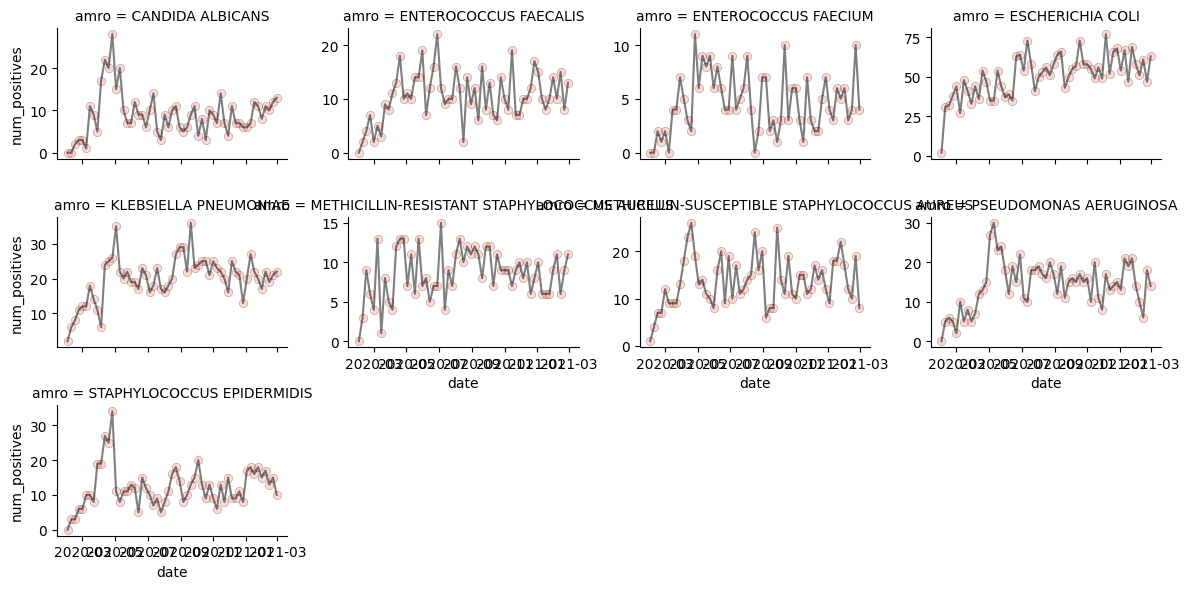

In [30]:
data_df = amro_df.groupby(["date", "amro"]).sum()[["num_positives"]].unstack([1]).resample("W-Sun").sum(numeric_only=False).stack().reset_index()
import seaborn as sns
g = sns.FacetGrid(data_df, col="amro", col_wrap=4, height=2, aspect=1.5, sharey=False)
g.map(sns.scatterplot, "date", "num_positives", edgecolor="k", facecolor="salmon", alpha=0.3)
g.map(sns.lineplot, "date", "num_positives", color="black", alpha=0.5)


In [31]:
amro_df.to_csv( os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" ))
